---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [4]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

25/04/13 22:24:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [5]:
df = df.dropna(subset=['SALARY'])
# 假设 'SALARY' 是目标变量，特征列为 'feature1', 'feature2', 'feature3'
from pyspark.ml.feature import VectorAssembler
# 假设目标变量是 'SALARY'，特征列为 'MIN_YEARS_EXPERIENCE' 和 'MAX_YEARS_EXPERIENCE'
assembler = VectorAssembler(inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"], outputCol="features")

# 转换数据
df_assembled = assembler.transform(df)

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# 创建 StringIndexer 对象（假设 'EMPLOYMENT_TYPE' 是分类列）
indexer = StringIndexer(inputCol="EMPLOYMENT_TYPE", outputCol="EMPLOYMENT_TYPE_INDEX")

# 使用 OneHotEncoder 进行独热编码
encoder = OneHotEncoder(inputCol="EMPLOYMENT_TYPE_INDEX", outputCol="EMPLOYMENT_TYPE_OHE")

# 将这两个步骤组合到一个 Pipeline 中
pipeline = Pipeline(stages=[indexer, encoder])

# 使用 Pipeline 转换数据
df_transformed = pipeline.fit(df).transform(df)

df_transformed.show()

from pyspark.ml.feature import VectorAssembler

df_cleaned = df.dropna(subset=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"])

assembler = VectorAssembler(inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"], outputCol="features", handleInvalid="skip")

df_assembled = assembler.transform(df_cleaned)

df_assembled.select("features").show(5) 




In [16]:
df = df.dropna(subset=['SALARY'])

assembler = VectorAssembler(inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"], outputCol="features")

df_assembled = assembler.transform(df)

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

indexer = StringIndexer(inputCol="EMPLOYMENT_TYPE", outputCol="EMPLOYMENT_TYPE_INDEX")

encoder = OneHotEncoder(inputCol="EMPLOYMENT_TYPE_INDEX", outputCol="EMPLOYMENT_TYPE_OHE")

pipeline = Pipeline(stages=[indexer, encoder])

df_transformed = pipeline.fit(df).transform(df)

df_transformed.show()

from pyspark.ml.feature import VectorAssembler

df_cleaned = df.dropna(subset=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"])

assembler = VectorAssembler(inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"], outputCol="features", handleInvalid="skip")

df_assembled = assembler.transform(df_cleaned)

df_assembled.select("features").show(5)





+--------------------+-----------------+----------------------+----------+---------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+--------------------+-------------------+--------------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+------------------+------+--------------------+-----+--------------------+-----+--------------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+-----

# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [18]:

seed = 99

train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=seed)

print(f"Train set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")


Train set size: 3010


[Stage 23:>                                                         (0 + 1) / 1]

Test set size: 746


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [76]:
from pyspark.ml.regression import LinearRegression


lr = LinearRegression(featuresCol="features", labelCol="SALARY")


lr_model = lr.fit(train_data)


print(f"coefficients: {lr_model.coefficients}")
print(f"intercept: {lr_model.intercept}")


25/04/14 22:16:23 WARN Instrumentation: [7ce1fa25] regParam is zero, which might cause numerical instability and overfitting.
25/04/14 22:16:26 WARN Instrumentation: [7ce1fa25] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
[Stage 80:>                                                         (0 + 1) / 1]

coefficients: [4392.664529597229,4392.664529597229]
intercept: 76149.42468927488


In [20]:
predictions = lr_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

r2_evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R²: {r2}")

mae_evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(predictions)
print(f"MAE: {mae}")


RMSE: 29556.38059030923


R²: 0.3020462962374868


[Stage 30:>                                                         (0 + 1) / 1]

MAE: 22719.038421297257


In [75]:

summary = lr_model.summary


coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f"Model intercept: {intercept}")
print(f"Model coefficients: {coefficients}")


print(f"RMSE: {summary.rootMeanSquaredError}")
print(f"R²: {summary.r2}")


import pandas as pd


features = ["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"]

summary_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients,
})


summary_df


Model intercept: 76149.42468927488
Model coefficients: [4392.664529597229,4392.664529597229]
RMSE: 29892.800597350197
R²: 0.33081363362973226


,Feature,Coefficient
0,MIN_YEARS_EXPERIENCE,4392.66453
1,MAX_YEARS_EXPERIENCE,4392.66453


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [47]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "REMOTE_TYPE"],
    outputCol="features",
    handleInvalid="skip"
)
df_assembled = assembler.transform(df).select("features", "SALARY")


glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",       
    regParam=0.01          
)


model = glr.fit(df_assembled)
summary = model.summary


print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)

print("Standard Errors:", summary.coefficientStandardErrors)
print("t-values:", summary.tValues)
print("p-values:", summary.pValues)



Coefficients: [4375.906536897755,4375.906500938741,1584.1816976570692]
Intercept: 75464.35067584798


[Stage 46:>                                                         (0 + 1) / 1]

Standard Errors: [275474.4806456303, 275474.4806456303, 779.633795775564, 944.5807313916771]
t-values: [0.015884979714425568, 0.01588497958389074, 2.0319561648570623, 79.8919014202886]
p-values: [0.9873269975319918, 0.9873269976261276, 0.042228408796390005, 0.0]


In [74]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression


assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "REMOTE_TYPE"],
    outputCol="features",
    handleInvalid="skip"
)
df_assembled = assembler.transform(df).select("features", "SALARY")


glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",       
    regParam=0.01            
)

model = glr.fit(df_assembled)
summary = model.summary


coefficients = [model.intercept] + list(model.coefficients)
t_values = summary.tValues
p_values = summary.pValues


feature_names = ["Intercept"] + features


summary_df = pd.DataFrame({
    "Feature": feature_names,
    "t-stat": t_values,
    "P-Value": p_values
})


summary_df


,Feature,t-stat,P-Value
0,Intercept,0.015885,0.987327
1,MIN_YEARS_EXPERIENCE,0.015885,0.987327
2,MAX_YEARS_EXPERIENCE,2.031956,0.042228
3,REMOTE_TYPE,79.891901,0.000000


# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


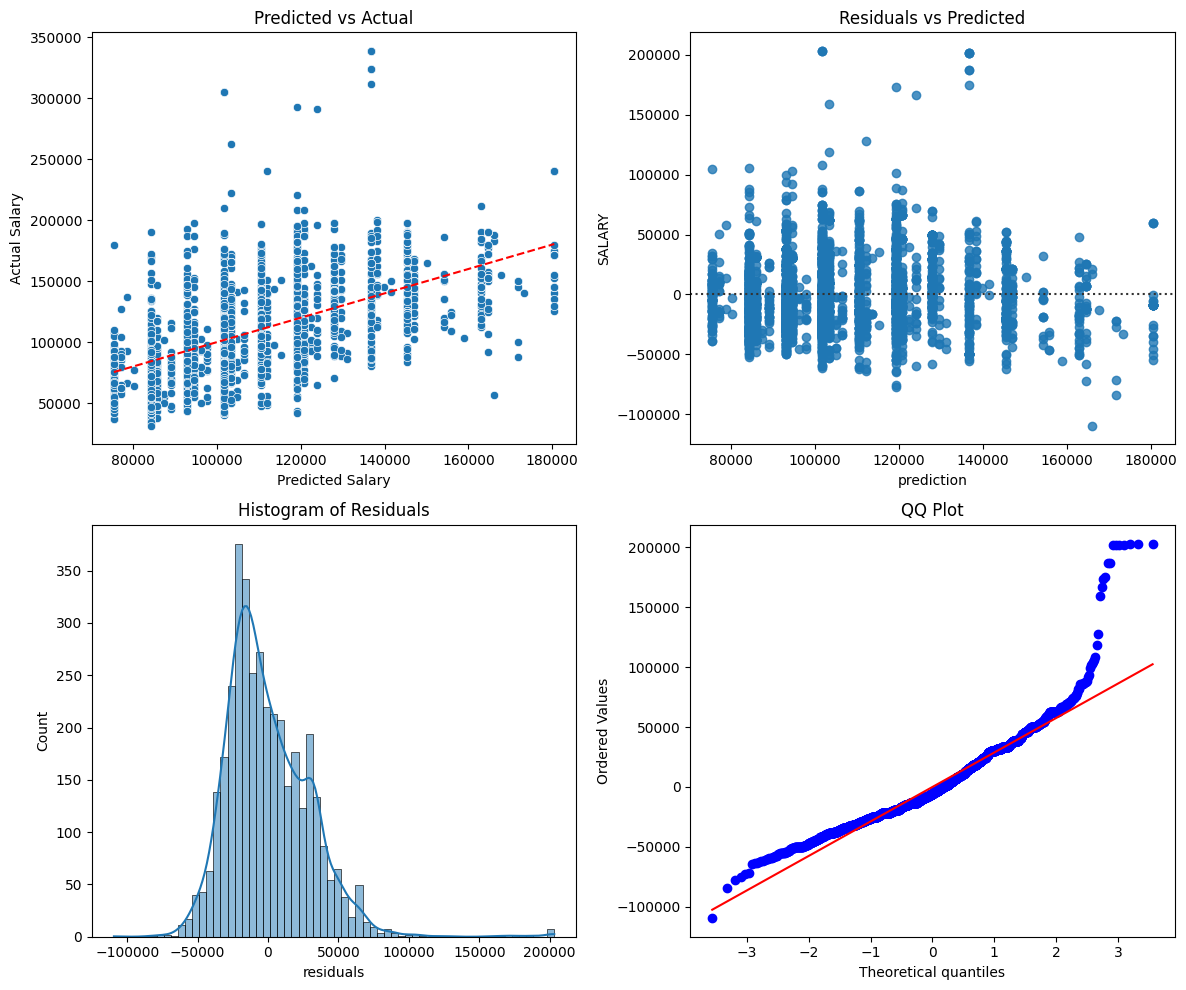

In [77]:
predictions = model.transform(df_assembled).select("SALARY", "prediction")
pred_pd = predictions.toPandas()

pred_pd["residuals"] = pred_pd["SALARY"] - pred_pd["prediction"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pred_pd["std_residuals"] = scaler.fit_transform(pred_pd[["residuals"]])

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.figure(figsize=(12, 10))

# 1. Predicted vs Actual
plt.subplot(2, 2, 1)
sns.scatterplot(x=pred_pd["prediction"], y=pred_pd["SALARY"])
plt.plot([pred_pd["prediction"].min(), pred_pd["prediction"].max()],
         [pred_pd["prediction"].min(), pred_pd["prediction"].max()], 'r--')
plt.title("Predicted vs Actual")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.savefig("_output/figure1.png") 


# 2. Residuals vs Predicted
plt.subplot(2, 2, 2)
sns.residplot(x=pred_pd["prediction"], y=pred_pd["SALARY"], line_kws={'color': 'red'})
plt.title("Residuals vs Predicted")
plt.savefig("_output/figure2.png")

# 3. Histogram of Residuals
plt.subplot(2, 2, 3)
sns.histplot(pred_pd["residuals"], kde=True)
plt.title("Histogram of Residuals")
plt.savefig("_output/figure3.png")

# 4. QQ Plot of Residuals
plt.subplot(2, 2, 4)
stats.probplot(pred_pd["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot")
plt.savefig("_output/figure4.png")

plt.tight_layout()
plt.show()


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [60]:

pred_pd = predictions.select("SALARY", "prediction").toPandas()

pred_pd["residuals"] = pred_pd["SALARY"] - pred_pd["prediction"]


In [71]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

aic = summary.aic

print({rmse},{r2},{aic})


[Stage 74:>                                                         (0 + 1) / 1]

{29808.02646345893} {0.3269802367869231} {88061.69401198748}


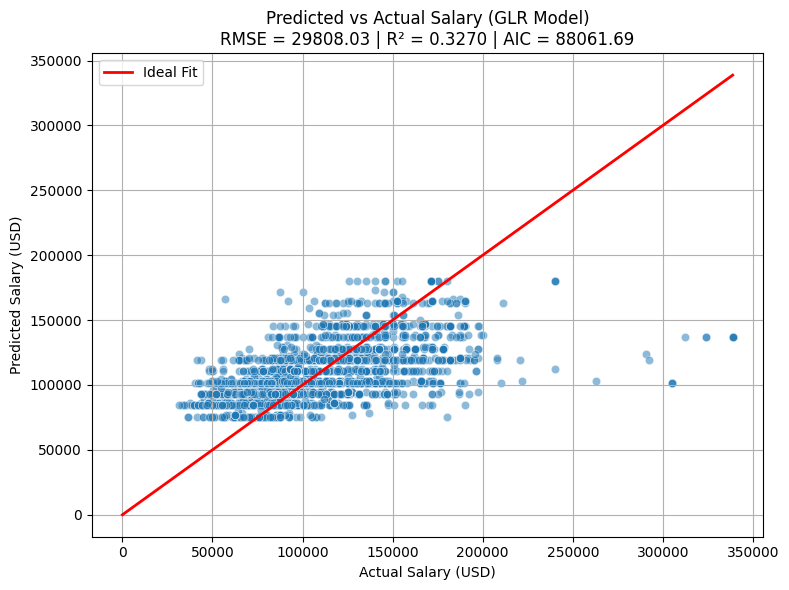

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pred_pd, x="SALARY", y="prediction", alpha=0.5)

max_val = max(pred_pd["SALARY"].max(), pred_pd["prediction"].max())
plt.plot([0, max_val], [0, max_val], color="red", linestyle="-", linewidth=2, label="Ideal Fit")

plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f}")
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("_output/figure5.png")
plt.show()



## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

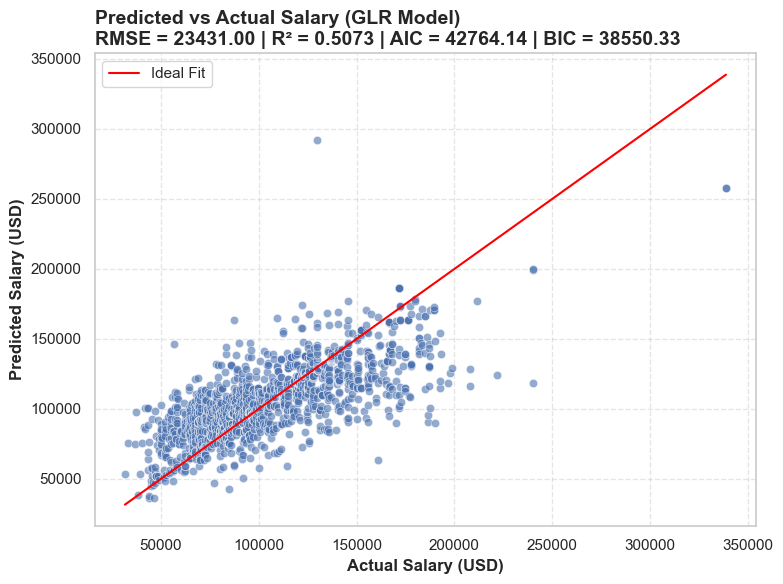

In [ ]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = 

# Plot
plt.figure(figsize=(8, 6))


plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}", loc="left", fontsize=14, fontweight="bold")

plt.tight_layout()

# Save figure
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
